In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sklearn.metrics as metrics

In [2]:
class PCA:
  def __init__(self, data: pd.DataFrame, classes = pd.Series) -> None:
    self.__data = data
    self.__classes = classes  
    self.__eigval: np.ndarray = None
    self.__eigvec: np.ndarray = None
    self.__x_adj: pd.DataFrame = None
    self.__cov_adj: pd.DataFrame = None
    self.__sort_idx: np.ndarray = None
    self.__cal_pca()

  def __cal_pca(self):
    self.__x_adj = (self.__data - self.__data.mean()) 
    self.__cov_adj = self.__x_adj.cov()
    self.__eigval, self.__eigvec = np.linalg.eig(self.__cov_adj)
    self.__sort_idx = np.argsort(self.__eigval)[::-1]
    self.__eigvec = self.__eigvec.T

  def eigvec(self, n: int = None) -> np.ndarray:
    if n == None:
      return self.__eigvec
    
    return self.__eigvec[self.__sort_idx[:n]]
  
  def eigval(self, n: int = None) -> np.ndarray:
    if n == None:
      return self.__eigval

    return self.__eigval[self.__sort_idx[:n]]
  
  def project(self, n: int) -> pd.DataFrame:
    max_eigvec = self.eigvec(n)
    new_x = max_eigvec.dot(self.__x_adj.T).T
    new_x = pd.DataFrame(new_x)
    new_x.columns = [f"PC{i+1}" for i in range(n)]
    new_x["class"] = self.__classes
    return new_x
  
  def per_var_of(self, n: int) -> float:
    return self.eigval(n).sum() / self.eigval().sum()
  
  def eig_var(self) -> list[float]:
    sum_val = self.__eigval.sum()
    return [ e / sum_val for e in self.__eigval]

In [3]:
def kmean(X: np.ndarray, k, distance_fn, init_centers: np.ndarray = None, loops = 1000):
  old_centers = None
  if init_centers is None:
    old_centers = X[np.random.choice(X.shape[0], size=k, replace=False), :].copy()
  else:  
    old_centers = init_centers.copy()
  print(old_centers)
  old_lables = []
  for i in range(loops):
    new_labels = []
    for x in X:
      new_labels.append(np.argmin([distance_fn(x, c) for c in old_centers]))

    new_centers = np.zeros((k, X.shape[1]), dtype=float)
    count = np.zeros(k)
    for i, x in enumerate(X):
      new_centers[new_labels[i]] += x
      count[new_labels[i]] += 1

    for i, c in enumerate(new_centers):
      new_centers[i] /= count[i]

    if (old_centers == new_centers).all():
      old_centers = new_centers
      old_lables = new_labels
      break

    old_centers = new_centers
    old_lables = new_labels

  print("loop", i)
  return np.array(old_lables), old_centers


In [4]:
def distribute_centroids(data, k):
    # Compute the bounding box for each dimension
    bounding_box_min = np.min(data, axis=0)
    bounding_box_max = np.max(data, axis=0)

    # Calculate centroid spacing for each dimension
    centroid_spacing = (bounding_box_max - bounding_box_min) / (k - 1)

    # Initialize centroids
    centroids = []
    for i in range(k):
        centroid = bounding_box_min + i * centroid_spacing
        centroids.append(centroid)

    return np.array(centroids)

In [5]:
def euclidean(x: np.ndarray, y: np.ndarray):
  return np.linalg.norm(x - y, 2, 0)

def manhattan(x: np.ndarray, y: np.ndarray):
  return np.linalg.norm(x - y, 1, 0)

def sum_sq(x: np.ndarray, y: np.ndarray):
  return np.sum((x - y)**2)

def cos(x: np.ndarray, y: np.ndarray):
  return  np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [6]:
X = np.array([
  [3, 0],
  [3.2, 0],
  [4, 0],
  [4, 4],
  [4.2, 4.2],
  [0, 4.2],
  [0, 4],
])

In [7]:
k = [2, 3, 4, 5, 6]

# Different k on iris dataset

In [8]:
X = pd.read_csv("./iris/iris.data")
X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
X_data = X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values

[[4.8 3.4 1.9 0.2]
 [6.9 3.2 5.7 2.3]
 [6.1 2.6 5.6 1.4]]
loop 2
0.663046326431084


Text(0, 0.5, 'sepal_width')

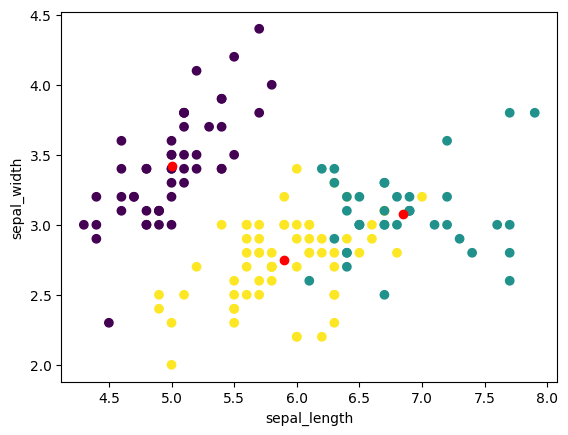

In [9]:
labels, centers = kmean(X_data, 3, euclidean)
print(metrics.davies_bouldin_score(X_data, labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width") 

[[5.5 2.3 4.  1.3]
 [5.6 2.5 3.9 1.1]
 [5.8 2.7 5.1 1.9]]
loop 2
0.6601464870925771


Text(0, 0.5, 'sepal_width')

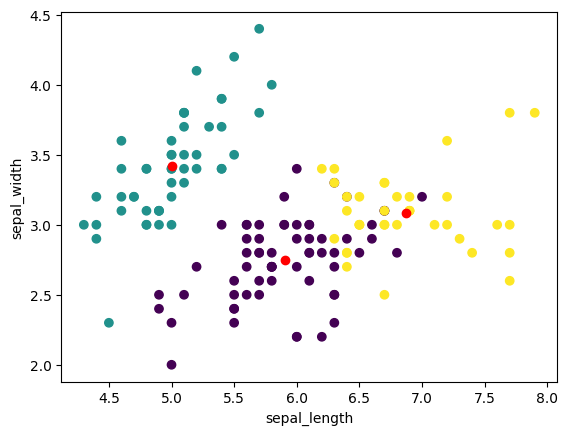

In [10]:
labels, centers = kmean(X_data, 3, manhattan)
print(metrics.davies_bouldin_score(X_data, labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

[[6.8 3.2 5.9 2.3]
 [5.7 2.5 5.  2. ]
 [4.8 3.4 1.9 0.2]]
loop 2
0.663046326431084


Text(0, 0.5, 'sepal_width')

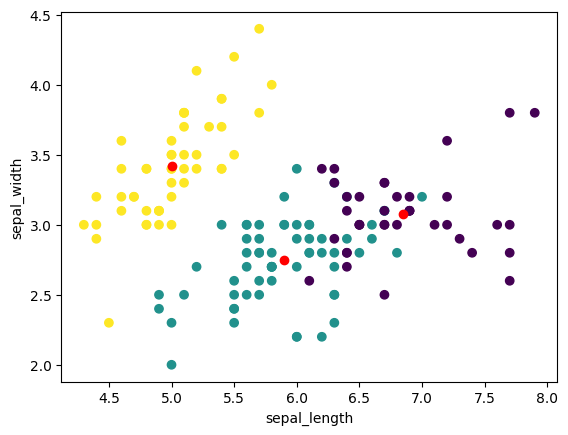

In [11]:
labels, centers = kmean(X_data, 3, sum_sq)
print(metrics.davies_bouldin_score(X_data, labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

[[4.3 3.  1.1 0.1]
 [5.6 2.9 3.6 1.3]]
loop 1
k = 2
[[5.7 3.  4.2 1.2]
 [6.7 3.  5.2 2.3]
 [5.8 2.7 4.1 1. ]]
loop 2
k = 3
[[5.1 3.8 1.5 0.3]
 [6.4 3.2 5.3 2.3]
 [6.4 3.2 4.5 1.5]
 [6.3 2.3 4.4 1.3]]
loop 3
k = 4
[[6.  3.4 4.5 1.6]
 [6.4 2.8 5.6 2.2]
 [5.  3.4 1.5 0.2]
 [5.  2.  3.5 1. ]
 [5.  3.2 1.2 0.2]]
loop 4
k = 5
[[5.8 2.7 4.1 1. ]
 [5.4 3.  4.5 1.5]
 [5.9 3.2 4.8 1.8]
 [5.4 3.9 1.7 0.4]
 [6.3 3.3 4.7 1.6]
 [6.6 2.9 4.6 1.3]]
loop 5
k = 6


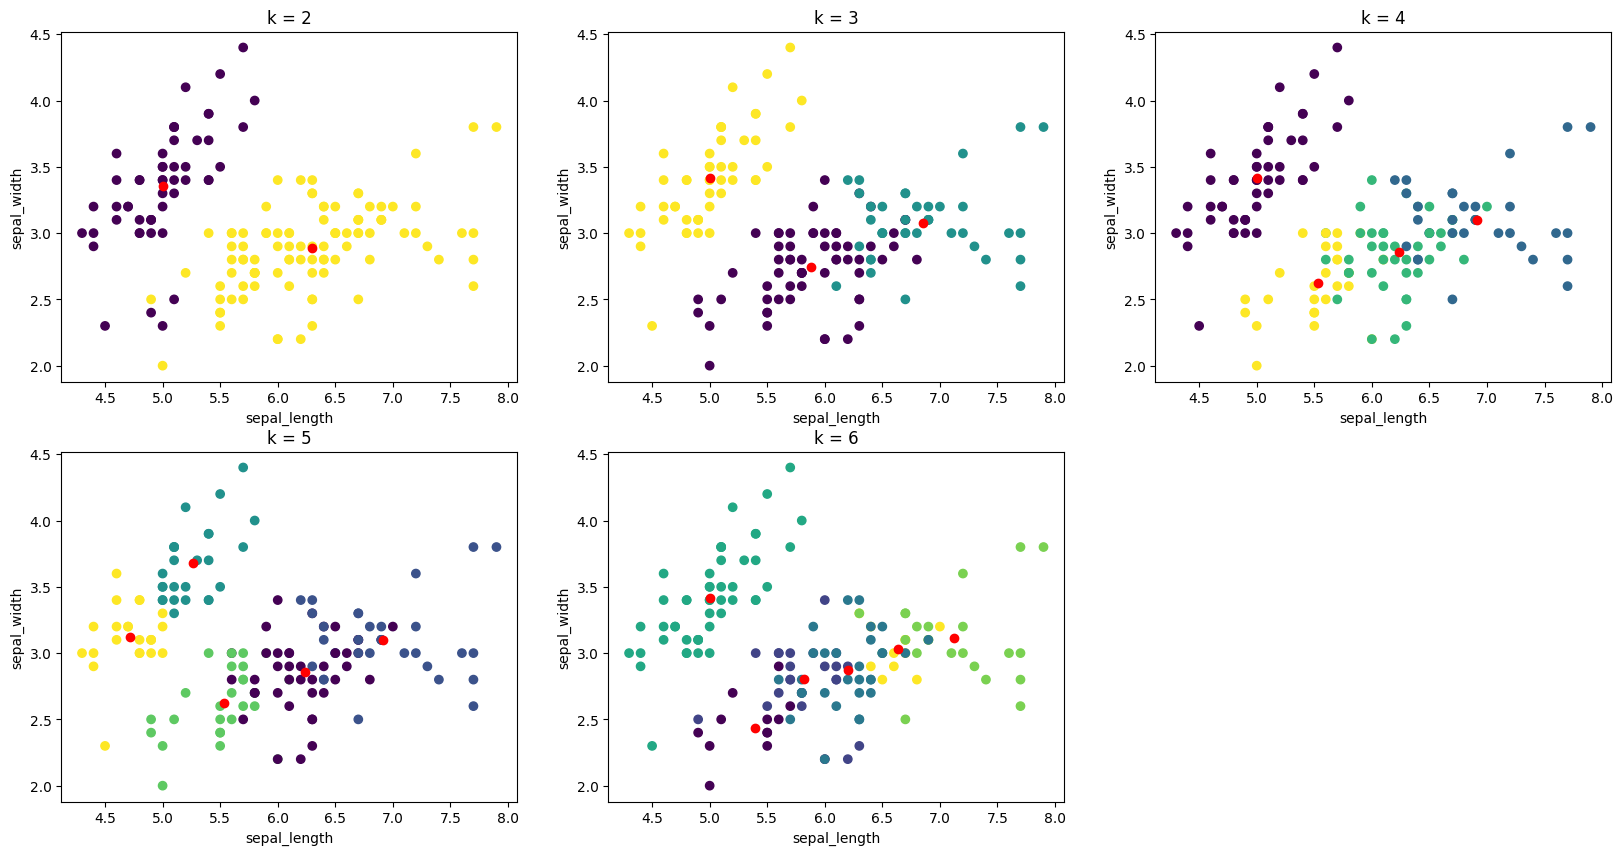

In [12]:
# apply k mean with k in k and subplot
list = []
for i in k:
    labels, centers = kmean(X_data, i, euclidean)
    print(f"k = {i}")
    list.append(metrics.davies_bouldin_score(X_data, labels))
    
    plt.subplot(2, 3, i - 1)
    plt.title(f"k = {i}")
    plt.gcf().set_size_inches(20, 10)
    plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
    plt.scatter(centers[:,0], centers[:,1], c="red")
    # add name of x and y 
    plt.xlabel("sepal_length")
    plt.ylabel("sepal_width")
plt.show()

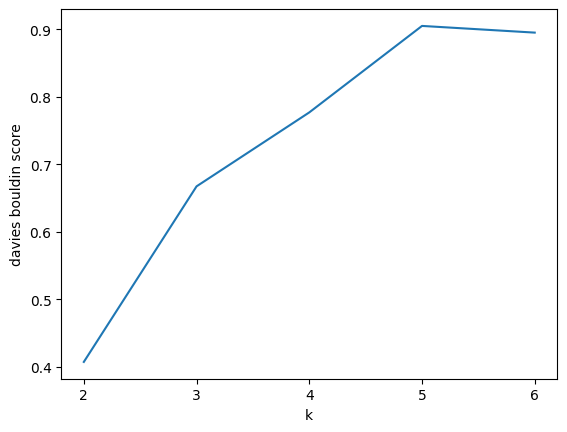

In [13]:
# plot the davies bouldin score with k is int
plt.plot(k, list)
plt.xlabel("k")
plt.xticks(k)
plt.ylabel("davies bouldin score")
plt.show()

# Different k on rice dataset

In [14]:
X = pd.read_csv("./Rice_Cammeo_Osmancik.csv")
X.columns = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length', 'class']
X_data = X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']].values

[[1.08970000e+04 4.20554993e+02 1.68118652e+02 8.35630112e+01
  8.67723107e-01 1.11740000e+04 6.40849233e-01]
 [1.34430000e+04 4.59730988e+02 1.88012360e+02 9.26948242e+01
  8.70015025e-01 1.37070000e+04 7.42010295e-01]]
loop 1
0.5273001110862959


Text(0, 0.5, 'sepal_width')

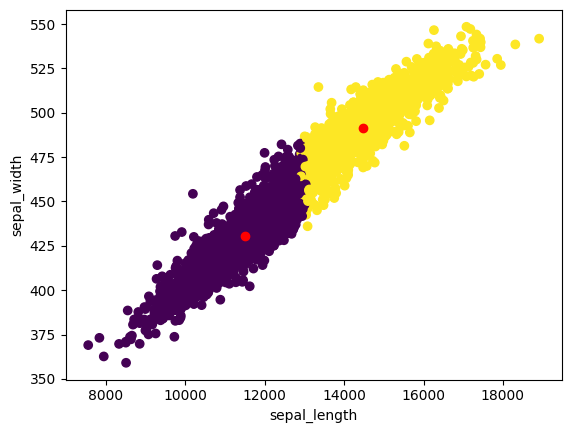

In [15]:
labels, centers = kmean(X_data, 2, euclidean)
print(metrics.davies_bouldin_score(X_data, labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

[[1.21710000e+04 4.31949005e+02 1.74380020e+02 9.00505753e+01
  8.56344998e-01 1.23660000e+04 6.18822455e-01]
 [1.17650000e+04 4.29292999e+02 1.75063080e+02 8.67285995e+01
  8.68657351e-01 1.19690000e+04 6.11168802e-01]]
loop 1
0.5274130356851247


Text(0, 0.5, 'sepal_width')

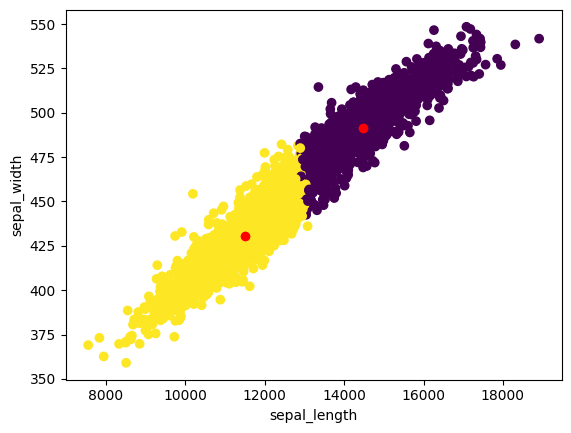

In [16]:
labels, centers = kmean(X_data, 2, manhattan)
print(metrics.davies_bouldin_score(X_data, labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

[[1.23110000e+04 4.50334991e+02 1.94446747e+02 8.13193436e+01
  9.08350885e-01 1.24410000e+04 5.56555152e-01]
 [1.30450000e+04 4.46006012e+02 1.74689774e+02 9.64560165e+01
  8.33740771e-01 1.33510000e+04 6.32791638e-01]
 [1.46760000e+04 4.81631012e+02 2.02402069e+02 9.29472351e+01
  8.88322175e-01 1.49360000e+04 6.50531888e-01]]
loop 2
0.5561762926051376


Text(0, 0.5, 'sepal_width')

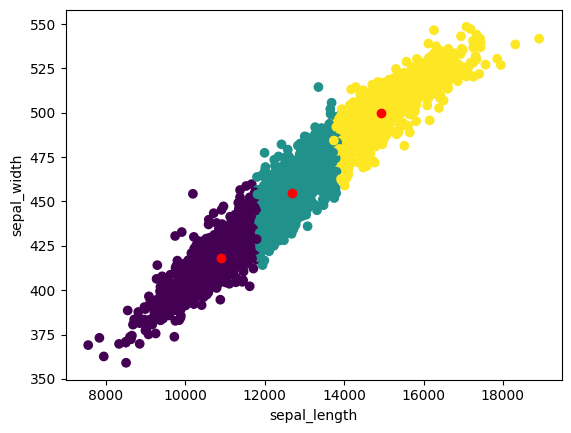

In [17]:
labels, centers = kmean(X_data, 3, sum_sq)
print(metrics.davies_bouldin_score(X_data, labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

[[1.03820000e+04 4.05213013e+02 1.68426270e+02 7.89587173e+01
  8.83302808e-01 1.05990000e+04 8.01822662e-01]
 [1.13290000e+04 4.19404999e+02 1.73390457e+02 8.43458252e+01
  8.73708308e-01 1.15600000e+04 8.03247333e-01]]
loop 1
k = 2
[[1.25930000e+04 4.63368988e+02 1.95757629e+02 8.30796661e+01
  9.05474484e-01 1.29070000e+04 6.97750449e-01]
 [1.38580000e+04 4.75368988e+02 2.01442032e+02 8.79232483e+01
  8.99719179e-01 1.40830000e+04 7.78539300e-01]
 [1.26880000e+04 4.66838013e+02 1.93786667e+02 8.43717041e+01
  9.00244594e-01 1.29560000e+04 6.01897538e-01]]
loop 2
k = 3
[[1.36970000e+04 4.82384003e+02 2.06734451e+02 8.51809311e+01
  9.11170006e-01 1.39270000e+04 5.97079337e-01]
 [1.15490000e+04 4.25220001e+02 1.74226974e+02 8.57846527e+01
  8.70384336e-01 1.18050000e+04 6.30128741e-01]
 [9.66800000e+03 3.93713989e+02 1.59522934e+02 7.84907684e+01
  8.70575786e-01 9.88200000e+03 6.04174495e-01]
 [1.62260000e+04 5.17684021e+02 2.17080566e+02 9.59383774e+01
  8.97040546e-01 1.64660000e+0

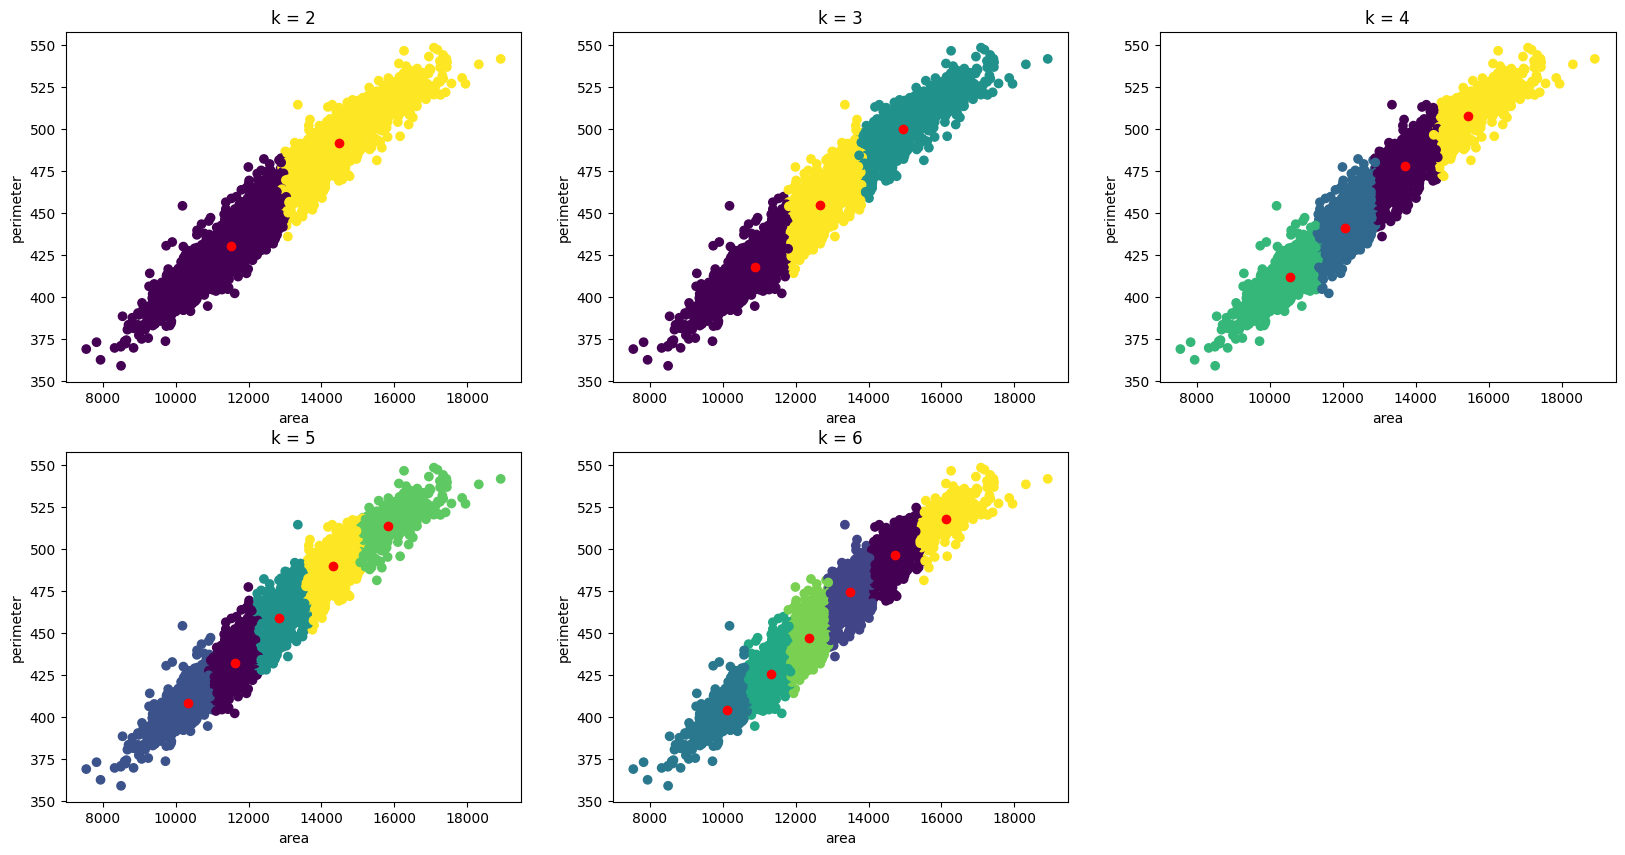

In [18]:
# apply k mean with k in k and subplot
list = []
for i in k:
    labels, centers = kmean(X_data, i, euclidean)
    print(f"k = {i}")
    list.append(metrics.davies_bouldin_score(X_data, labels))
    
    plt.subplot(2, 3, i - 1)
    plt.title(f"k = {i}")
    plt.gcf().set_size_inches(20, 10)
    plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
    plt.scatter(centers[:,0], centers[:,1], c="red")
    # add name of x and y 
    plt.xlabel("area")
    plt.ylabel("perimeter")
plt.show()

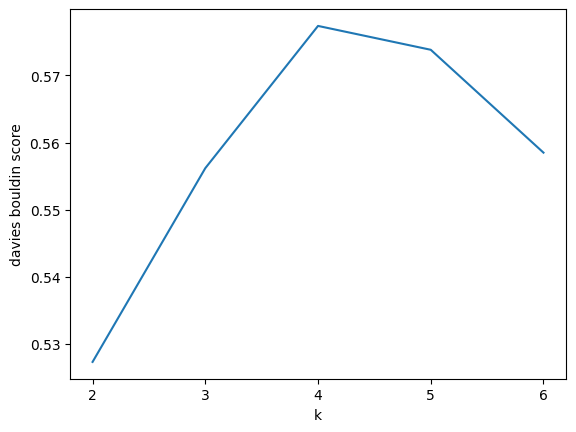

In [19]:
# plot the davies bouldin score with k is int
plt.plot(k, list)
plt.xlabel("k")
plt.xticks(k)
plt.ylabel("davies bouldin score")
plt.show()

# Apply PCA and then Kmean for iris dataset

In [20]:
X = pd.read_csv("./iris/iris.data")
X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
X_data = X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values

[[-2.90682876  0.56422248]
 [-2.85867044  0.21405407]
 [ 1.15056621  0.16395972]]
loop 2


Text(0, 0.5, 'PC2')

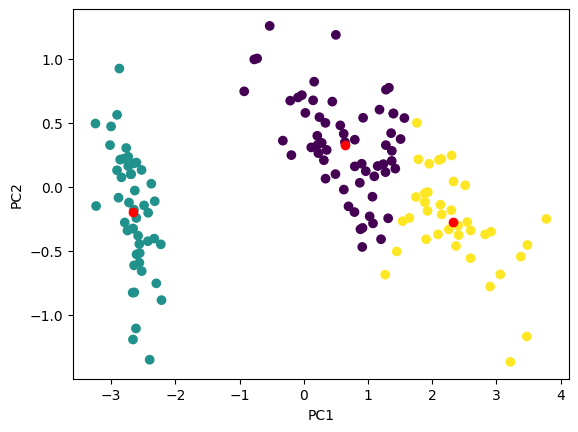

In [21]:
pca = PCA(X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] , X['class'])
pca = pca.project(2).drop(columns=["class"])
labels, centers = kmean(pca.values, 3, euclidean)
plt.scatter(pca.values[:,0], pca.values[:,1], c=labels)
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("PC1")
plt.ylabel("PC2")

In [22]:
print("Davies Bouldin Score: ", metrics.davies_bouldin_score(pca.values, labels))

Davies Bouldin Score:  0.5656970645543343


[[-3.24397251 -1.36784329]
 [ 0.26656464 -0.0541311 ]
 [ 3.77710179  1.2595811 ]]
loop 2


Text(0, 0.5, 'PC2')

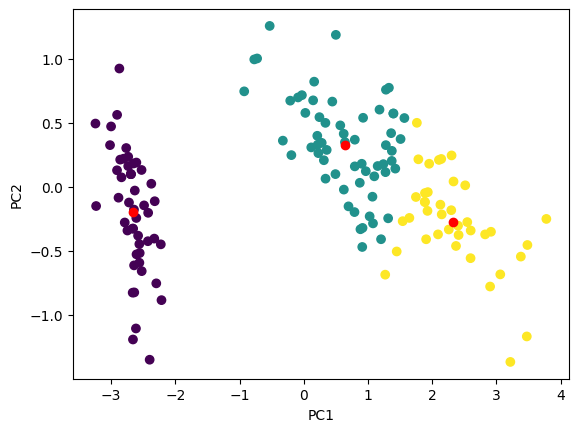

In [23]:
pca = PCA(X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] , X['class'])
pca = pca.project(2).drop(columns=["class"])
intial_centers = distribute_centroids(pca.values, 3)
labels, centers = kmean(pca.values, 3, euclidean, intial_centers)
plt.scatter(pca.values[:,0], pca.values[:,1], c=labels)
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Apply Kmean and then PCA for iris dataset

In [24]:
X = pd.read_csv("./iris/iris.data")
X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
X_data = X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values

[[5.  3.4 1.5 0.2]
 [7.6 3.  6.6 2.1]
 [5.1 3.3 1.7 0.5]]
loop 2


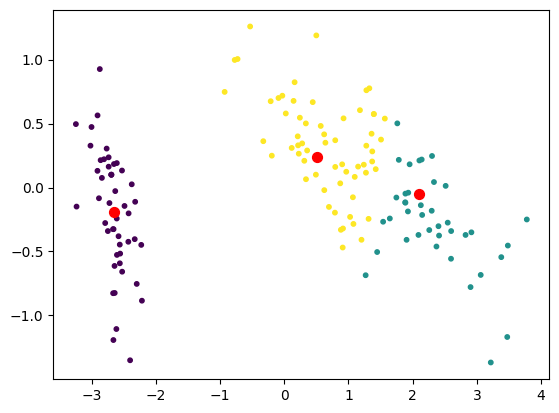

In [25]:
labels, centers = kmean(X_data, 3, euclidean)
pca = PCA(X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] , X['class'])
pca_data = pca.project(2)
plt.scatter(pca_data.values[:,0], pca_data.values[:,1], c=labels, s=10)
plt.scatter(pca_data.groupby("class").mean()["PC1"], pca_data.groupby("class").mean()["PC2"], c='red', s=50)

In [26]:
print("Davies Bouldin Score: ", metrics.davies_bouldin_score(pca_data.drop(columns=["class"]).values, labels))

Davies Bouldin Score:  0.5656970645543343


# Apply PCA and then Kmean for rice dataset

In [27]:
X = pd.read_csv("./Rice_Cammeo_Osmancik.csv")
X.columns = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length', 'class']
X_data = X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']].values

In [28]:
pca = PCA(X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']] , X['class'])

              PC1         PC2
0    -2906.884391   55.766668
1    -2807.184614  -10.349166
2     -653.302524  -74.044643
3    -3065.462204  165.886196
4    -1164.359707    1.262429
...           ...         ...
3804  1804.187408  -46.784642
3805  1478.089762   14.084423
3806   380.421061  -49.694077
3807  3988.860379    1.093360
3808  1835.768987  -68.125665

[3809 rows x 2 columns]
[[-287.65876923   38.70199968]
 [1676.18608046  -21.90255065]]
loop 1


Text(0, 0.5, 'PC2')

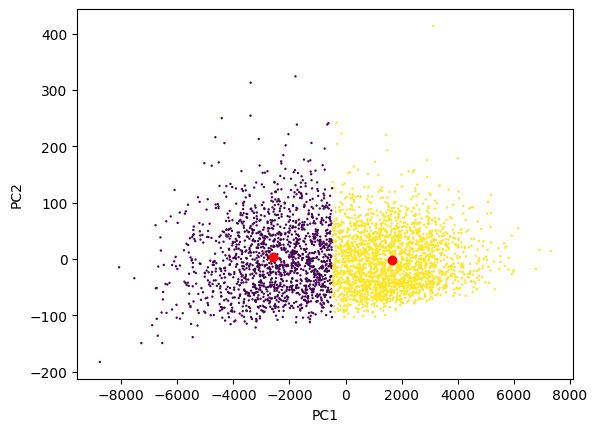

In [29]:
pca = pca.project(2).drop(columns=["class"])
print(pca)
labels, centers = kmean(pca.values, 2, euclidean)
plt.scatter(pca.values[:,0], pca.values[:,1], c=labels, s=0.5)
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("PC1")
plt.ylabel("PC2")

In [30]:
print("Davies Bouldin Score: ", metrics.davies_bouldin_score(pca.values, labels))

Davies Bouldin Score:  0.5272309033554218


# Apply Kmean and then PCA for Rice dataset

In [31]:
X = pd.read_csv("./Rice_Cammeo_Osmancik.csv")
X.columns = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length', 'class']
X_data = X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']].values

[[1.31740000e+04 4.80576996e+02 2.03506454e+02 8.34204407e+01
  9.12123501e-01 1.36060000e+04 5.49466133e-01]
 [1.16380000e+04 4.51009003e+02 1.95036133e+02 7.69290314e+01
  9.18923914e-01 1.18430000e+04 5.40598273e-01]]
loop 1


Text(0, 0.5, 'PC2')

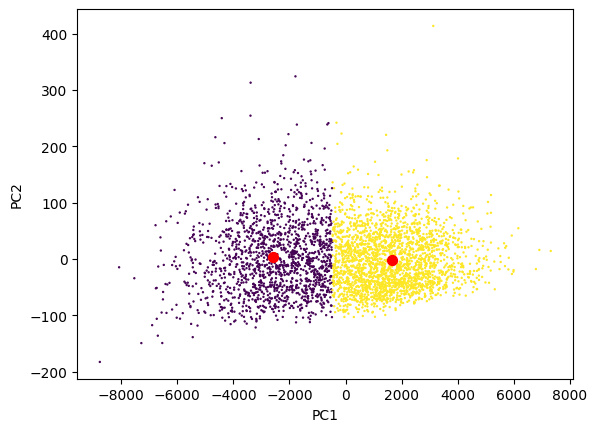

In [32]:
labels, centers = kmean(X_data, 2, euclidean)
pca = PCA(X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']] , labels)
# plot the centroids of pca
pca_data = pca.project(2)
plt.scatter(pca_data.values[:,0], pca_data.values[:,1], c=labels, s=0.5)
plt.scatter(pca_data.groupby("class").mean()["PC1"], pca_data.groupby("class").mean()["PC2"], c='red', s=50)
plt.xlabel("PC1")
plt.ylabel("PC2")

In [33]:
pca_data = pca_data.drop(columns=["class"])
print("Davies Bouldin Score: ", metrics.davies_bouldin_score(pca_data.values, labels))

Davies Bouldin Score:  0.5272309033554218
